# Alberto Doncel Pedrosa

## Implementación RESNET 

La siguiente práctica tiene por objetivo implementar una ResNet junto con un catálago amplio de optimizadores. Uno de los aspectos más  relevantes es observar de qué forma una red compleja y entranada se acopla de manera óptima a una salida final que pueda clasificar el dataset CIFAR100. Se realizaran, junto a la optimización, diversos experimentos para feterminar esto último

Paquetes necesarios

In [1]:
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import tensorflow as tf
from aux_func import show_history, r2_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Conv2DTranspose, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset
import time


In [2]:
from tensorflow.keras.datasets import cifar100

(X_train_cifar100, y_train_cifar100), (X_validation_cifar100, y_validation_cifar100) = cifar100.load_data()
X_train_cifar100 = X_train_cifar100/255
X_validation_cifar100 = X_validation_cifar100/255

Puesto que se va a realizar numerosas pruebas se debe asignar la red en un objeto nuevo cada vez que se realice un experimento determinado. De otra forma podrían existir errores al quitar capas de la red preconstruido o sobreentrenar modelos.

In [3]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

## Modelo base

In [4]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-50].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output
# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dense(units=150, activation='ReLU')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=25,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

2022-01-23 20:36:13.835486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2022-01-23 20:36:14.461695: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
1000/1000 [==============================] - 28s 22ms/step - loss: 2.8373 - accuracy: 0.2880 - val_loss: 3.4242 - val_accuracy: 0.2076
Epoch 2/25
1000/1000 [==============================] - 22s 22ms/step - loss: 2.0488 - accuracy: 0.4490 - val_loss: 2.2097 - val_accuracy: 0.4205
Epoch 3/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.7076 - accuracy: 0.5284 - val_loss: 2.5511 - val_accuracy: 0.3839
Epoch 4/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.4240 - accuracy: 0.5927 - val_loss: 2.3527 - val_accuracy: 0.4313
Epoch 5/25
1000/1000 [==============================] - 22s 22ms/step - loss: 1.1778 - accuracy: 0.6543 - val_loss: 2.1784 - val_accuracy: 0.4521
Epoch 6/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.9568 - accuracy: 0.7117 - val_loss: 2.7675 - val_accuracy: 0.4001
Epoch 7/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7616 - accuracy: 0.7646 - val_loss: 2.4399 -

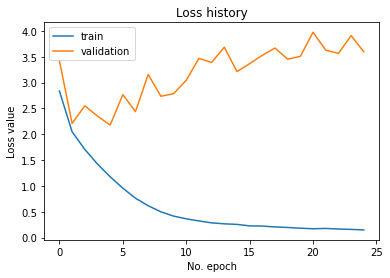

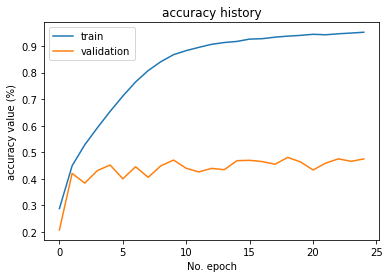

In [5]:
show_history(history)

## Modelo reducido

Se observa la existencia de overfitting, puesto que vamos a reducir nuevamente el modelo prescinciendo de menos capas con el objetivo de reducir dicha posibilidad. En una primera aproximación podemos inferir que la red es excesivamente compleja para el DataSet que se le está incorporando

In [6]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


In [7]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output  

# Seleccionamos hasta que capa del modelo base queremos conservar
layer = Flatten()(last_layer_model_base)
layer = Dense(units=150, activation='ReLU')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# Creamos el modelo de clasificación que irá encima del modelo base modificado
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=25,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

2022-01-23 20:45:41.767719: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2022-01-23 20:45:42.364902: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
1000/1000 [==============================] - 16s 14ms/step - loss: 3.1089 - accuracy: 0.2409 - val_loss: 3.8155 - val_accuracy: 0.1977
Epoch 2/25
1000/1000 [==============================] - 13s 13ms/step - loss: 2.2342 - accuracy: 0.4042 - val_loss: 2.4171 - val_accuracy: 0.3782
Epoch 3/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.9039 - accuracy: 0.4803 - val_loss: 2.6410 - val_accuracy: 0.3507
Epoch 4/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.6724 - accuracy: 0.5270 - val_loss: 2.5674 - val_accuracy: 0.3872
Epoch 5/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.4646 - accuracy: 0.5773 - val_loss: 2.5693 - val_accuracy: 0.3894
Epoch 6/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.2850 - accuracy: 0.6228 - val_loss: 2.2351 - val_accuracy: 0.4479
Epoch 7/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.0933 - accuracy: 0.6705 - val_loss: 2.4082 -

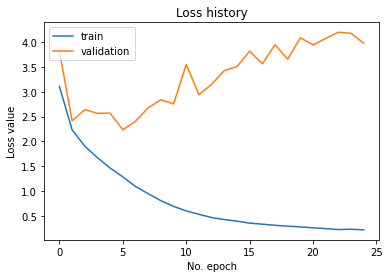

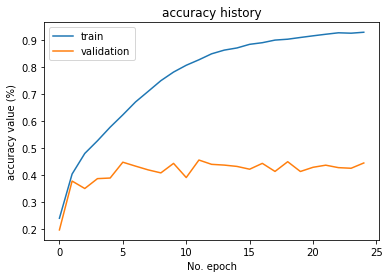

In [8]:
show_history(history)

In [9]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


## Modelo Dropout

Continuamos teniendo overfitting, por lo que se incorpora el apagado de neuronas.

In [10]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=20,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

2022-01-23 20:51:22.653689: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/20
1000/1000 [==============================] - 16s 14ms/step - loss: 3.3677 - accuracy: 0.1981 - val_loss: 3.1448 - val_accuracy: 0.2295
Epoch 2/20
1000/1000 [==============================] - 14s 14ms/step - loss: 2.4727 - accuracy: 0.3498 - val_loss: 2.5393 - val_accuracy: 0.3459
Epoch 3/20
1000/1000 [==============================] - 13s 13ms/step - loss: 2.1553 - accuracy: 0.4178 - val_loss: 2.3526 - val_accuracy: 0.3894
Epoch 4/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.9383 - accuracy: 0.4690 - val_loss: 2.2126 - val_accuracy: 0.4229
Epoch 5/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.7560 - accuracy: 0.5056 - val_loss: 2.5063 - val_accuracy: 0.3787
Epoch 6/20
1000/1000 [==============================] - 13s 13ms/step - loss: 1.5963 - accuracy: 0.5421 - val_loss: 2.2213 - val_accuracy: 0.4391
Epoch 7/20
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4586 - accuracy: 0.5790 - val_loss: 2.2571 -

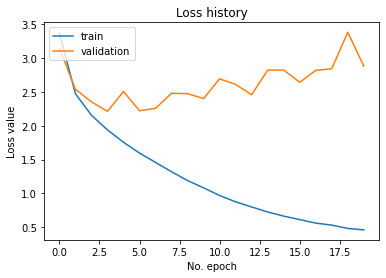

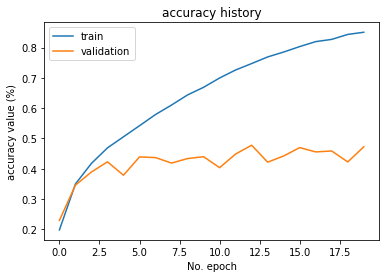

In [11]:
show_history(history)

Se observa como perdura el overfitting del entrenamiento, lo que da muestras de que el modelo es demasiado complejo para el conjunto de entrenamiento.

## Modelo Early Stopping

In [12]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


In [13]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [14]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=25,
                    validation_data=(X_validation_cifar100, y_validation_cifar100), callbacks=[early_stopping])


Epoch 1/25
1000/1000 [==============================] - 16s 14ms/step - loss: 3.3264 - accuracy: 0.2023 - val_loss: 3.2100 - val_accuracy: 0.2214
Epoch 2/25
1000/1000 [==============================] - 13s 13ms/step - loss: 2.4463 - accuracy: 0.3558 - val_loss: 3.5085 - val_accuracy: 0.2227
Epoch 3/25
1000/1000 [==============================] - 13s 13ms/step - loss: 2.1428 - accuracy: 0.4223 - val_loss: 2.1834 - val_accuracy: 0.4221
Epoch 4/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.9357 - accuracy: 0.4644 - val_loss: 2.6328 - val_accuracy: 0.3576
Epoch 5/25
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7576 - accuracy: 0.5080 - val_loss: 2.6573 - val_accuracy: 0.3583
Epoch 6/25
1000/1000 [==============================] - 13s 13ms/step - loss: 1.5940 - accuracy: 0.5442 - val_loss: 2.2305 - val_accuracy: 0.4343
Epoch 7/25
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4509 - accuracy: 0.5769 - val_loss: 2.2872 -

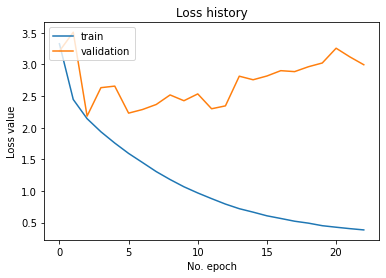

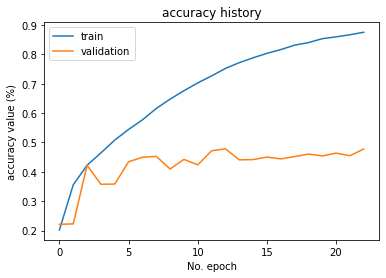

In [15]:
show_history(history)

In [16]:
print("Evaluate on validation data")
results = model.evaluate(X_validation_cifar100, y_validation_cifar100, batch_size=128)
print('val loss:',results[0], 'val acc:', results[1])

Evaluate on validation data
79/79 [==============================] - 1s 8ms/step - loss: 2.3452 - accuracy: 0.4783
val loss: 2.3451647758483887 val acc: 0.478300005197525


## Regularización Lasso

In [17]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


In [18]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu', kernel_regularizer=l2(0.001))(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs= input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=25,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

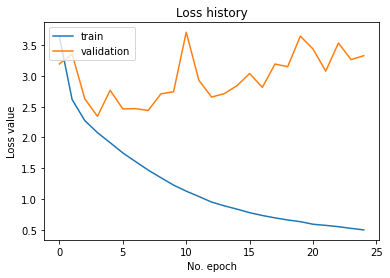

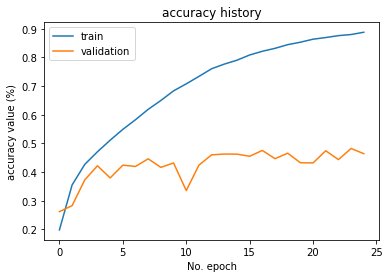

In [19]:
show_history(history)

## Data augmentation

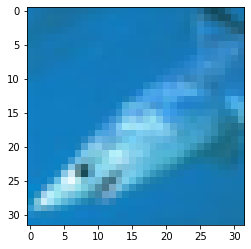

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


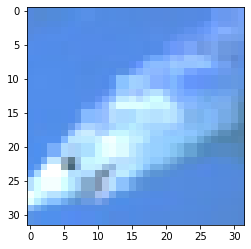

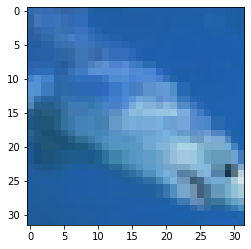

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


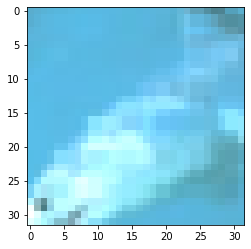

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


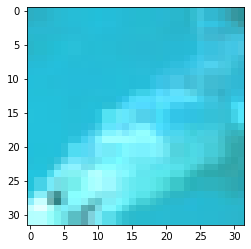

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


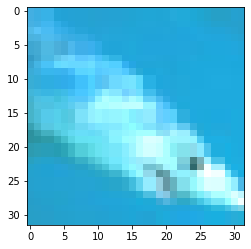

In [20]:
import matplotlib.pyplot as plt
from tensorflow.data import Dataset

# Creamos un Dataset utilizando numpys
train_ds = Dataset.from_tensor_slices((X_train_cifar100, y_train_cifar100))
val_ds = Dataset.from_tensor_slices((X_validation_cifar100, y_validation_cifar100))

# Seleccionamos el batch_size que
batch_size = 50

# Creamos una función que perturbará de forma aleatoria las imágenes.
# Las etiquetas quedan invariantes
def processing_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.resize(image, (40,40), method='nearest',antialias=False)
    image = tf.image.random_crop(image, (32,32,3))
    return image, label



# Esta función hará las modificaciones pertinentes al dataset para poder usarlo durante el entrenamiento
def data_aug(ds: Dataset, shuffle=False, augment=False):
    # Hacemos que el dataset se repita de manera indefinida
    ds = ds.repeat()

    # Aleatorizamos el dataset usando un buffer de 5000
    if shuffle:
        ds = ds.shuffle(5000)

    # Aplicamos las transformaciones pertinentes
    if augment:
        ds = ds.map(processing_data,num_parallel_calls=4)

    # Hacemos que el dataset este formado por batches
    ds = ds.batch(batch_size)

    # Devolvemos el dataset precargándolo
    return ds.prefetch(buffer_size=4)

# Aplicamos la función data_aug a nuestro dataset
train_ds = data_aug(train_ds, shuffle=True, augment=True)
# Al dataset de validación no le aplicamos perturbaciones
val_ds = data_aug(val_ds)


# Visualizemos unos ejemplos de como la función processing_data modifica las imágenes
plt.imshow(X_train_cifar100[50])
plt.show()
for _ in range(5):
    image_mod = np.array(processing_data(X_train_cifar100[50], 0)[0])
    plt.imshow(image_mod)
    plt.show()

In [21]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [22]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [23]:
# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Usamos los dataset creados con tensorflow.data.Dataset para entrenar nuesto modelo
history = model.fit(train_ds, batch_size=60, epochs=15,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=200)

Epoch 1/15
1000/1000 [==============================] - 18s 16ms/step - loss: 3.7344 - accuracy: 0.1326 - val_loss: 4.6702 - val_accuracy: 0.1064
Epoch 2/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.9706 - accuracy: 0.2479 - val_loss: 3.2918 - val_accuracy: 0.2311
Epoch 3/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.6977 - accuracy: 0.3076 - val_loss: 3.1430 - val_accuracy: 0.2727
Epoch 4/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.5331 - accuracy: 0.3391 - val_loss: 2.6500 - val_accuracy: 0.3329
Epoch 5/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3970 - accuracy: 0.3704 - val_loss: 2.4857 - val_accuracy: 0.3636
Epoch 6/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.2980 - accuracy: 0.3912 - val_loss: 2.8738 - val_accuracy: 0.3130
Epoch 7/15
1000/1000 [==============================] - 16s 16ms/step - loss: 2.2166 - accuracy: 0.4092 - val_loss: 2.5600 -

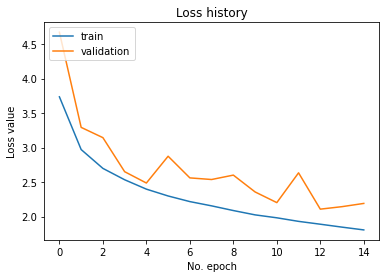

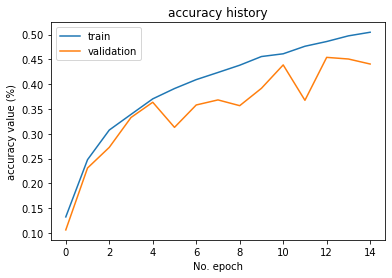

In [24]:
show_history(history)

## Batch size correcto

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

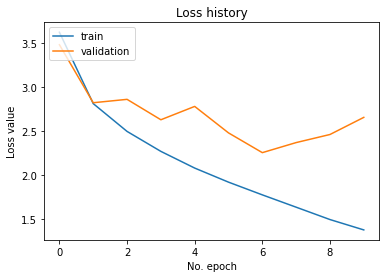

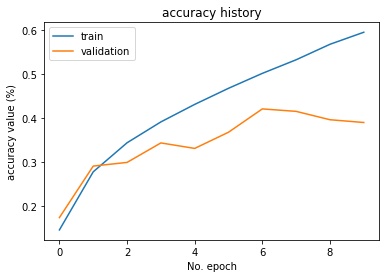

79/79 [==============================] - 1s 7ms/step - loss: 2.2545 - accuracy: 0.4203
###################################################################################################################################
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                       

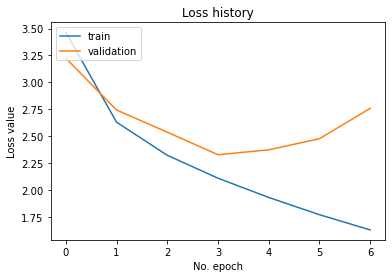

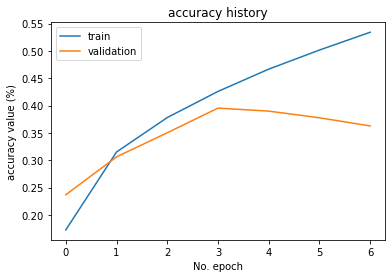

79/79 [==============================] - 1s 7ms/step - loss: 2.3275 - accuracy: 0.3955
###################################################################################################################################
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                       

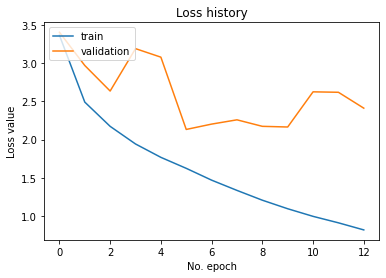

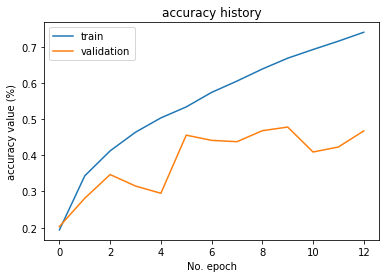

79/79 [==============================] - 1s 7ms/step - loss: 2.1640 - accuracy: 0.4782
###################################################################################################################################


In [25]:
scores = []
epochs_train = []


for bs in (20,30,50):
    model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)
    # El input del nuevo modelo será el mismo que el modelo base
    input = model.input

    # Seleccionamos hasta que capa del modelo base queremos conservar
    last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

    # Creamos el modelo de clasificación que irá encima del modelo base modificado
    layer = Flatten()(last_layer_model_base)
    layer = Dropout(0.6)(layer)
    layer = Dense(units=200, activation='relu')(layer)
    output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

    # creamos el modelo
    model = Model(inputs= input, outputs=output)
    print(model.summary())

    # optimizador
    optimizer = Adam(learning_rate=0.001)

    # función loss
    loss = SparseCategoricalCrossentropy(from_logits=False)

    # métrica
    metrics = ['accuracy']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

    history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=bs, epochs=15,
                    validation_data=(X_validation_cifar100, y_validation_cifar100), callbacks=[early_stopping])
    
    show_history(history)
    
    scores.append(model.evaluate(X_validation_cifar100, y_validation_cifar100, batch_size=128)[1])
    epochs_train.append(len(history.history['loss']))
    
    
    
    print('###################################################################################################################################')
    


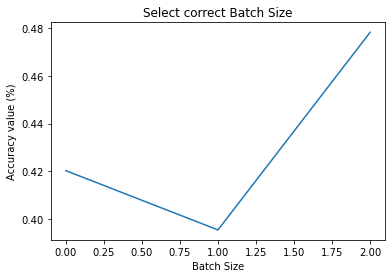

In [26]:
plt.plot(scores)
plt.title('Select correct Batch Size')
plt.ylabel('Accuracy value (%)')
plt.xlabel('Batch Size')
plt.show()

## Batch Normalization

In [27]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


In [28]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado

layer = Flatten()(last_layer_model_base)
layer = BatchNormalization()(layer)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs= input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=25,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

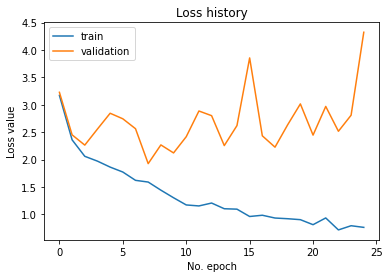

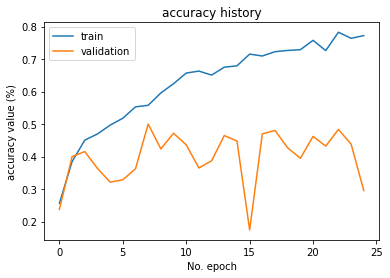

In [29]:
show_history(history)

## Tamaño correcto

Se incorpora como experimento final un modelo en el que se va a probar en bucle la implementación de la RESNET pero con diferentes niveles de profundidad con el objetivo de conocer si existe una relación inversa para nuestros datos entre complejidad del modelo y resultados. Es de

In [30]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


Epoch 1/15
1000/1000 [==============================] - 16s 15ms/step - loss: 3.2307 - accuracy: 0.2507 - val_loss: 4.9047 - val_accuracy: 0.1210
Epoch 2/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.3481 - accuracy: 0.3897 - val_loss: 2.4835 - val_accuracy: 0.3640
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.1076 - accuracy: 0.4364 - val_loss: 3.1138 - val_accuracy: 0.2602
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8972 - accuracy: 0.4851 - val_loss: 2.8007 - val_accuracy: 0.3182
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7951 - accuracy: 0.5099 - val_loss: 2.5582 - val_accuracy: 0.3760
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.6722 - accuracy: 0.5377 - val_loss: 2.2451 - val_accuracy: 0.4190
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.6104 - accuracy: 0.5531 - val_loss: 3.6172 -

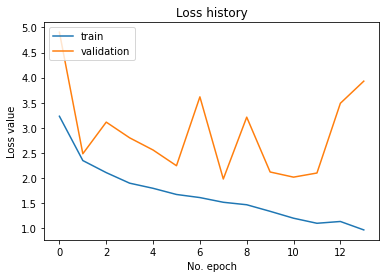

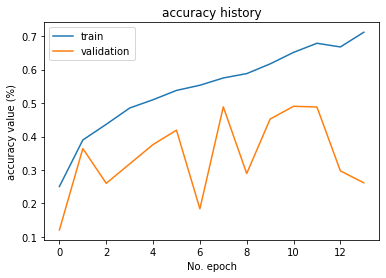

Epoch 1/15
1000/1000 [==============================] - 17s 15ms/step - loss: 3.2672 - accuracy: 0.2507 - val_loss: 2.8575 - val_accuracy: 0.2894
Epoch 2/15
1000/1000 [==============================] - 15s 15ms/step - loss: 2.3478 - accuracy: 0.3919 - val_loss: 3.1965 - val_accuracy: 0.2764
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0398 - accuracy: 0.4519 - val_loss: 2.3382 - val_accuracy: 0.4073
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8448 - accuracy: 0.4961 - val_loss: 2.3019 - val_accuracy: 0.4208
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.6788 - accuracy: 0.5312 - val_loss: 2.1421 - val_accuracy: 0.4469
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5422 - accuracy: 0.5648 - val_loss: 2.3814 - val_accuracy: 0.4252
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.4092 - accuracy: 0.5938 - val_loss: 2.4816 -

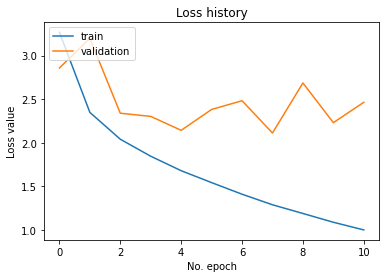

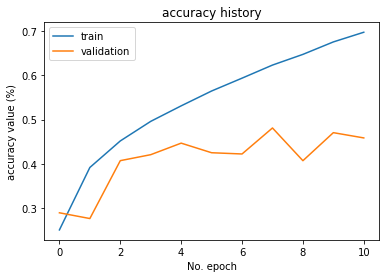

Epoch 1/15
1000/1000 [==============================] - 17s 15ms/step - loss: 3.1548 - accuracy: 0.2581 - val_loss: 2.9200 - val_accuracy: 0.2753
Epoch 2/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.3859 - accuracy: 0.3816 - val_loss: 7.8167 - val_accuracy: 0.0920
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.1933 - accuracy: 0.4224 - val_loss: 3.4042 - val_accuracy: 0.2113
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9320 - accuracy: 0.4776 - val_loss: 2.7242 - val_accuracy: 0.3647
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8187 - accuracy: 0.5011 - val_loss: 2.3726 - val_accuracy: 0.4051
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7895 - accuracy: 0.5117 - val_loss: 2.5937 - val_accuracy: 0.3806
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5969 - accuracy: 0.5593 - val_loss: 1.9771 -

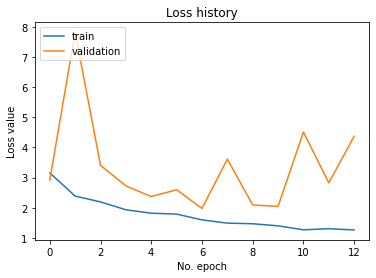

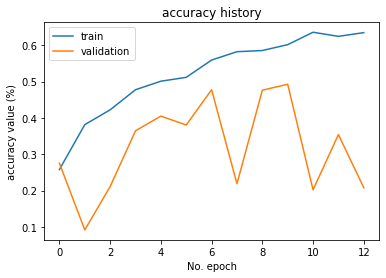

Epoch 1/15
1000/1000 [==============================] - 17s 15ms/step - loss: 3.1128 - accuracy: 0.2557 - val_loss: 2.8109 - val_accuracy: 0.2982
Epoch 2/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.4038 - accuracy: 0.3770 - val_loss: 2.3944 - val_accuracy: 0.3768
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.1792 - accuracy: 0.4270 - val_loss: 3.3738 - val_accuracy: 0.2368
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.0727 - accuracy: 0.4487 - val_loss: 2.2846 - val_accuracy: 0.4052
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9127 - accuracy: 0.4842 - val_loss: 2.4321 - val_accuracy: 0.3855
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.9275 - accuracy: 0.4839 - val_loss: 3.2703 - val_accuracy: 0.2965
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7415 - accuracy: 0.5239 - val_loss: 2.0475 -

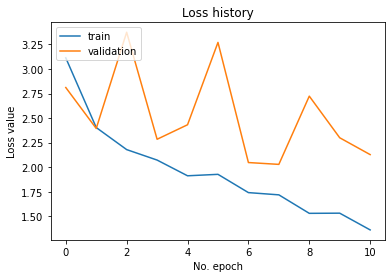

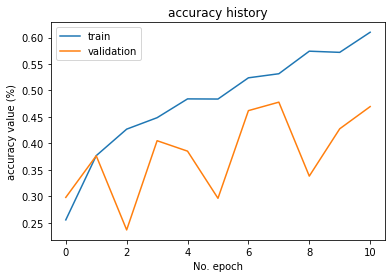

Epoch 1/15
1000/1000 [==============================] - 16s 15ms/step - loss: 3.1488 - accuracy: 0.2598 - val_loss: 2.5789 - val_accuracy: 0.3443
Epoch 2/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.3700 - accuracy: 0.3818 - val_loss: 2.5028 - val_accuracy: 0.3668
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 2.1109 - accuracy: 0.4403 - val_loss: 2.2892 - val_accuracy: 0.4020
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.8853 - accuracy: 0.4883 - val_loss: 2.3076 - val_accuracy: 0.4115
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.7414 - accuracy: 0.5195 - val_loss: 2.3930 - val_accuracy: 0.4243
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.6189 - accuracy: 0.5478 - val_loss: 1.9440 - val_accuracy: 0.4767
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 1.5228 - accuracy: 0.5705 - val_loss: 4.4727 -

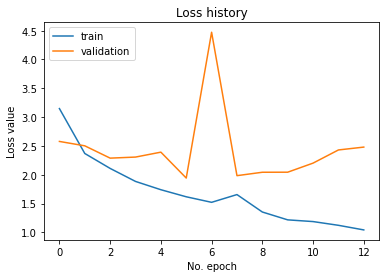

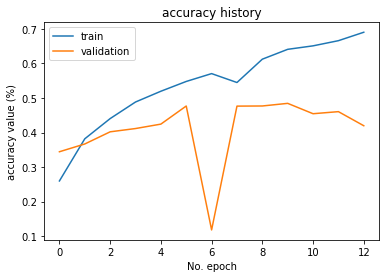

In [31]:
time_prediction = []
scores = []

for neuronas in (-100, -125, -150, -200, -230):
    
    model = tf.keras.applications.ResNet50(
    include_top=False,
    weights= 'imagenet',
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100)
    
    
    # El input del nuevo modelo será el mismo que el modelo base
    input = model.input

    # Seleccionamos hasta que capa del modelo base queremos conservar
    last_layer_model_base = model.layers[-100].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

    # Creamos el modelo de clasificación que irá encima del modelo base modificado

    layer = Flatten()(last_layer_model_base)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.6)(layer)
    layer = Dense(units=200, activation='relu')(layer)
    output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

    # creamos el modelo
    model = Model(inputs= input, outputs=output)
    
        # optimizador
    optimizer = Adam(learning_rate=0.001)

    # función loss
    loss = SparseCategoricalCrossentropy(from_logits=False)

    # métrica
    metrics = ['accuracy']

    # compilamos el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

    history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=15,
                        validation_data=(X_validation_cifar100, y_validation_cifar100), callbacks=[early_stopping])
    
    show_history(history)



Se incorpora con el fin de conocer resultados distintos y profundidar en el cógido fuente, la implementación de la RESNET pero sin incorporar los pesos de su pre entrenamiento y poder comparar modelos

In [32]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights = None,
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling= max,
    classes=100
)


In [33]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-50].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output
# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dense(units=150, activation='ReLU')(layer)
output = Dense(units=100, activation='softmax')(layer) #El output es 10 porque las etiquetas con las que se está entrenando es 10.

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=X_train_cifar100, y=y_train_cifar100, batch_size=50, epochs=30,
                    validation_data=(X_validation_cifar100, y_validation_cifar100))

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_17[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

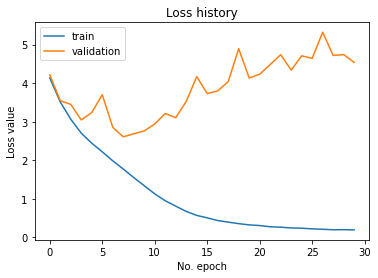

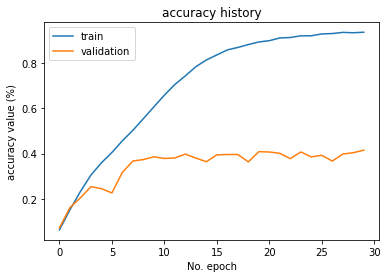

In [34]:
show_history(history)

## Conclusiones

- RESNET ofrece numerosas posibilidades de arquitectura; sin embargo, se debe prestar atención si se incorporan datos de entrada más simples que el propio modelo, como es nuestro caso
- Los resultados más adecuados se han obtenido con Data Augmentation, debido a que se ha contrarrestado la fuerza de la NN con una importante modificación del Dataset
- El experimento final permite encontrar una relación inversa entre complejidad de la red y resultados ya que cuanto más se reduce el modelo, parece que el modelo se comporta mejor. Esto nos lleva a deducir que la red podría implementarse con imágenes más complejos que las que ofrece CIFAR100.
- El hecho de que la RED esté entrenada y se ajuste bien al dataset se observa en los gráficos de relación respecto al número de épocas, apareciendo overfitting en las primeras épocas de cada modelo.
- En conclusión, RESNET presenta una arquitectura de gran versatilidad que resulta adecuada para proyectos con datos de entrada de mayor complejidad
